### https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-automating-pong-in-using-a-policy-model-an-implementation-b71f64c158ff

In [0]:
import numpy as np
import gym

In [0]:
#gym initialization
env = gym.make('Pong-v0')
observation = env.reset()
prev_input = None

In [0]:
#Declaring the two actions that can happen in Pong for an agent move up or down
#Declaring 0 means staing still. Note that this is pre-defined specific to package
UP_ACTION = 2
DOWN_ACTION = 3

In [0]:
#Hyperparameters. gamma here allows you to measure the effect of future events
gamma = 0.99

In [0]:
#initialization of variables used in the main loop
X_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

In [0]:
#Let's take a look at the game in action.
import matplotlib.pyplot as plt


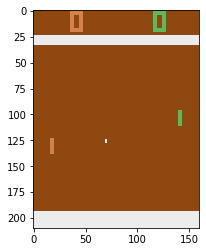

In [11]:
env = gym.make('Pong-v0') #environment info
observation = env.reset()
# the ball is released after 20 frames
for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()
  observation,_,_,_ = env.step(1)

In [0]:
def prepro(I):
  """
    prepro 210 X 160 X 3 frame into 6400 (80 x 80) 1D float vector
  """
  I = I[35:195] #crop
  I = I[::2, ::2, 0] #downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 #everything else(paddles, ball just set to 1)
  return I.astype(np.float).ravel()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


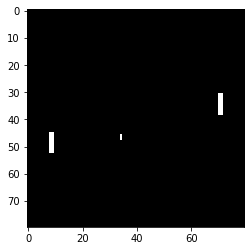

In [30]:
#Show preprocessed
obs_preprocessed = prepro(observation).reshape(80, 80)
print(obs_preprocessed)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

In [0]:
def discount_rewards(r, gamma):
  """
    take 1D float array of rewards and compute discounted reward 
  """
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0:
      running_add = 0 # if the game ended(in Pong), reset
  running_add = running_add * gamma + r[t]
  discounted_r[t] = running_add
  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.mean(discounted_r) #idem using standard deviation
  return discounted_r

In [0]:
#import necessary modules from keras
import keras.layers as kl
import keras
import keras.models as km
from keras.optimizers import Adam

In [33]:
"""
  The 80 x 80 input dimension comes from the pre-processing of the raw pizels made
  by Karpathy
  Input here represents the difference in pixels between one frame and another,
  giving you direction of agents and ball. Encoded in Karpathy's own preprocessing
  funcions
"""

model = km.Sequential()
#hidden layer takes a pre-processed frame as input and has 200 units. Simple layer architecture of 200 X 1, 1X1
model.add(kl.Dense(units=200, input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))

#output layer - we use a Sigmoid here, inorder to get a 0, or 1 value to represent ACTION UP
model.add(kl.Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))

#compile the model using traditional Machine learning losses and optimizers
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               1280200   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = []
observation = env.reset()
prev_input = None
#main traning loop
while(True):
  cur_input = prepro(observation)

  x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
  prev_input = cur_input

  #forward the policy network and sample action according to the probability distribution
  proba = model.predict(np.expand_dims(x, axis=1).T)

  action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
  y = 1 if action == 2 else 0 # 0 and 1 are out labels

  #log the input and label to train later
  X_train.append(x)
  y_train.append(y)

  observation, reward, done, info = env.step(action)

  rewards.append(reward)
  reward_sum += reward